# Regularization

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
print(f'Your tensorflow version is {tf.__version__}')
print(f'Your numpy version is {np.__version__}')

Your tensorflow version is 2.13.0
Your numpy version is 1.24.3


In [3]:
def shuffle_lists(x, y):
    data = list(zip(x, y))
    random.shuffle(data)
    x, y = zip(*data)
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

def normalize_data(data):
    mean = np.mean(data)
    dev = np.std(data)
    return (data - mean) / dev, mean, dev

def generate_data(lowest, highest, amount):
    x = np.linspace(lowest, highest, num=amount)
    y = []
    noise = 1000
    random.seed(123)

    for p in x:
        y.append(10 + 0.5*p - 0.04*p**2 + 0.002*p**3 + 0.0003*p**4 - 0.00001*p**5 + random.randint(-noise,noise)/100)
  
    return x, y 


Test loss: 46.17354965209961
4/4 [==============================] - 0s 0s/step


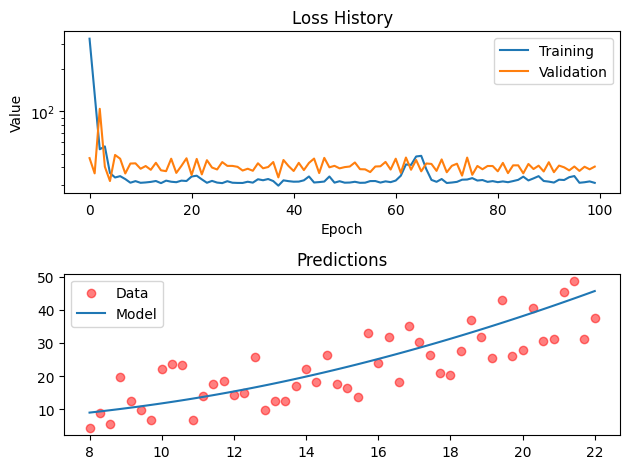

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.random import set_seed

# Model configuration
dropout   = False
batchnorm = False
normalize = False

batch_size = 16
no_epochs = 100
optimizer = Adam()
validation_split = 0.1
plot_name = "plot_default.pdf"

def custom_activation(x):
    return tf.math.square(x)

# Regularization techniques
if dropout:
    dropout_rate = 0.2
    plot_name = "plot_dropout.pdf"
if batchnorm:
    plot_name = "plot_batchnorm.pdf"

# Generate data
dataset_size = 100

# Ensure generate_data and shuffle_lists functions are defined and return NumPy arrays
x, y = generate_data(10, 20, dataset_size)
input_train, target_train =  shuffle_lists(x, y)

validation_size = 50
x, y = generate_data(8, 22, validation_size)
input_test, target_test =  shuffle_lists(x, y)

if normalize:
    input_train, mean_in, dev_in = normalize_data(input_train)
    target_train, mean_tar, dev_tar = normalize_data(target_train)
    input_test = (input_test - mean_in) / dev_in
    target_test = (target_test - mean_tar) / dev_tar

input_train  = input_train.reshape(len(input_train), 1)
target_train = target_train.reshape(len(target_train), 1)
input_test   = input_test.reshape(len(input_test), 1)
target_test  = target_test.reshape(len(target_test), 1)

input_train = input_train.astype(np.float32)
target_train = target_train.astype(np.float32)

# Create the model
model = Sequential()
model.add(Dense(16, activation=custom_activation, input_dim=1))
model.add(Dense(512, activation='elu'))
if dropout:
    model.add(Dropout(dropout_rate))
if batchnorm:
    model.add(BatchNormalization())
model.add(Dense(1, activation='elu'))

# Compile the model
model.compile(loss=MeanSquaredError(),
              optimizer=optimizer,
              metrics=['mean_squared_error'])

# Fit model to data
set_seed(123)
history = model.fit(input_train,
                    target_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=False,
                    validation_split=validation_split)

# Generate generalization metrics
score = model.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]}')

# Visualize history
fig, ax = plt.subplots(2, 1)

# Plot loss history
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_title('Loss History')
ax[0].set_ylabel('Value')
ax[0].set_yscale('log')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot predictions
if normalize:
    linspace = np.linspace(-2.5, 2.5, 100)
else:
    linspace = np.linspace(8, 22, 100)

linspace = linspace.reshape(-1, 1)

pred = model.predict(linspace)
ax[1].scatter(input_test, target_test, label='Data', color='red', alpha=0.5)
ax[1].plot(linspace, pred, label='Model')
ax[1].set_title('Predictions')
ax[1].legend()

# Save plot
plt.tight_layout()
plt.show()
